In [ ]:
import pandas as pd
import os
import re
import string
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 8})
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

我们主要采用`pandas`来导入数据，`matplotlib`进行绘图处理。对于探索性自然语言处理，我们主要使用`nltk`包来进行。最后几行代码规定了全局绘图的大小以及格式。没有最后一行代码指定以矢量图格式显示会导致`pyplot`绘制的图质量过低，难以阅读。

In [ ]:
train_data = pd.read_csv("/train.tsv/train.tsv",sep='\t',header=None,
                   names = ["index","sentence","phrase","sentiment"],dtype={"index":int,"sentence":int,"phrase":str,"sentiment":int})
print(train_data.head())

         index  sentence                                             phrase  \
0            1         1  A series of escapades demonstrating the adage ...   
1            2         1  A series of escapades demonstrating the adage ...   
2            3         1                                           A series   
3            4         1                                                  A   
4            5         1                                             series   
...        ...       ...                                                ...   
156055  156056      8544                                          Hearst 's   
156056  156057      8544                          forced avuncular chortles   
156057  156058      8544                                 avuncular chortles   
156058  156059      8544                                          avuncular   
156059  156060      8544                                           chortles   

        sentiment  
0               1  
1          

In [ ]:
test_data = pd.read_csv("/test.tsv/test.tsv",sep='\t',header=None,
                   names = ["index","sentence","phrase"],dtype={"index":int,"sentence":int,"phrase":str})
print(train_data.head())

为了处理的简便起见，我们在这一部分导入数据时在原始的tsv文件中把列名删除了，重新指定了列名并指定了每一列的数据类型，防止出现以外的类型转换问题。由之前的一些测试代码可以发现本数据的质量较好，没有缺失数据等，故不需要做这一步预处理。

以下是对于原问题的描述：

>该数据集由制表符分隔文件组成，其中包含来自Rotten Tomatoes数据集的短语。为了基准测试，保留了 train/test 拆分，但句子相对原始顺序，已重新排列。每个句子都已被 Stanford 解析器解析为许多短语。每个短语都有一个 PhraseId。每个句子都有一个 SentenceId。重复的短语（如短/常用词）在数据中仅包含一次。
 train.tsv 包含短语及其关联的情绪标签。我们还提供了一个 SentenceId，以便您可以跟踪哪些短语属于单个句子。
 test.tsv 仅包含短语。您必须为每个短语分配一个情绪标签。
 情绪标签包括：

>0 - negative

>1 - somewhat negative

>2 - neutral

>3 - somewhat positive

>4 - positive



## 探索性数据分析

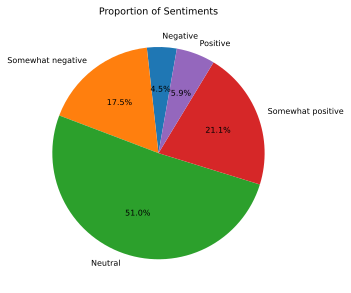

In [ ]:
train_data["phrase"] = train_data["phrase"].apply(lambda x: x.lower())
train_data["phrase"] = train_data["phrase"].apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x))

train_data_copy=train_data.copy(deep=True)

plt.pie(train_data_copy['sentiment'].value_counts().sort_index(),
        labels=['Negative','Somewhat negative','Neutral','Somewhat positive','Positive'],
        autopct='%1.1f%%',
        startangle=80
        )
plt.title('Proportion of Sentiments')
plt.show()

我们在这一步做了文本数据的预处理和一个初步统计。为了消除常见的干扰信息，我们去除了文本中的标点符号并将所有字母转为小写字母。我们对于情感类型的分布做了统计，结果显示Neutral占了一半以上，而最确定的Negative和Positive占比最少。这也非常符合本组数据将一个句子做树状拆分后，大部分短语的情感色彩为Neutral的特点。

Text(0.5, 1.0, 'Histogram of Phrase Lengths Distribution')

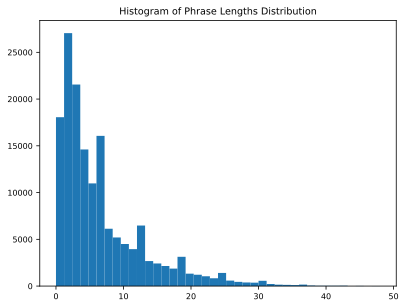

In [ ]:
train_data_copy['lens'] = train_data_copy['phrase'].apply(lambda x: len(x.split()))
train_data_copy['sentiment'] = train_data_copy['sentiment'].apply(lambda x: str(x).replace('0','Negative').replace('1','Somewhat negative').replace('2','Neutral').replace('3','Somewhat positive').replace('4','Positive'))
plt.hist(train_data_copy['lens'],bins=40)
plt.title('Histogram of Phrase Lengths Distribution')

然后我们分析了总体句长的分布。本组数据的句长分布呈现典型的偏态分布特征。结合数据的来源，可以推测其相对符合指数分布。

Text(0.5, 0.98, 'Histogram of Phrase Lengths Distribution By Sentiments')

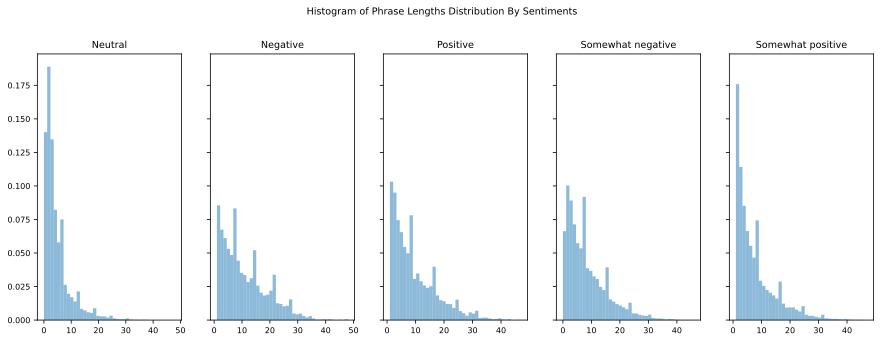

In [ ]:
df_neutral = train_data_copy[train_data_copy['sentiment'] == 'Neutral']
df_negative = train_data_copy[train_data_copy['sentiment'] == 'Negative']
df_positive = train_data_copy[train_data_copy['sentiment'] == 'Positive']
df_somewhat_negative = train_data_copy[train_data_copy['sentiment'] == 'Somewhat negative']
df_somewhat_positive = train_data_copy[train_data_copy['sentiment'] == 'Somewhat positive']

fig,(fig1,fig2,fig3,fig4,fig5) = plt.subplots(1,5,sharey="row",figsize=(15,5))
plt.subplots_adjust(top = 0.85)
fig1.hist(df_neutral['lens'],bins=40,label='Neutral',alpha=0.5,density=True)
fig1.set_title('Neutral')
fig2.hist(df_negative['lens'],bins=40,label='Negative',alpha=0.5,density=True)
fig2.set_title('Negative')
fig3.hist(df_positive['lens'],bins=40,label='Positive',alpha=0.5,density=True)
fig3.set_title('Positive')
fig4.hist(df_somewhat_negative['lens'],bins=40,label='Somewhat negative',alpha=0.5,density=True)
fig4.set_title('Somewhat negative')
fig5.hist(df_somewhat_positive['lens'],bins=40,label='Somewhat positive',alpha=0.5,density=True)
fig5.set_title('Somewhat positive')
plt.suptitle('Histogram of Phrase Lengths Distribution By Sentiments')

然后我们对于不同情感色彩的句长进行了分析，探讨其差异性。可以看到Neutral组的句长分布明显偏短，而注释有情感的短句长度会更高一些。但是所有组别的分布仍然都是短句远多于长句。这一方面说明了大部分短句可能都没有明显的感情色彩，另一方面也说明了长句的感情色彩仍然需要由决定性的短语来确定。

In [70]:
def WordFrecAnalysis(listA,outputnumber = 0):
    Estopwords = stopwords.words('english')
    Estopwords+=['movie','film','story','movies','one','two','people','films','work']
    
    wholelist = []
    for ps in listA:
        psT = word_tokenize(ps)
        psF = [word for word in psT if word not in Estopwords]
        wholelist+=psF
    fdist = FreqDist(wholelist)
    if outputnumber != 0:
        Common_words = fdist.most_common(outputnumber)
    else:
        Common_words = fdist.most_common()
    return Common_words
    

In [71]:
df_neutral_phrase = df_neutral["phrase"].tolist()
Neutral_Freq = WordFrecAnalysis(df_neutral_phrase,20)

In [72]:
df_negative_phrase = df_negative["phrase"].tolist()
Negative_Freq =WordFrecAnalysis(df_negative_phrase,20)

In [73]:
df_positive_phrase = df_positive["phrase"].tolist()
Positive_Freq = WordFrecAnalysis(df_positive_phrase,20)

In [74]:
df_somewhat_positive_phrase = df_somewhat_positive["phrase"].tolist()
Somewhat_positive_Freq = WordFrecAnalysis(df_somewhat_positive_phrase,20)

In [75]:
df_somewhat_negative_phrase = df_somewhat_negative["phrase"].tolist()
Somewhat_engative_Freq = WordFrecAnalysis(df_somewhat_negative_phrase,20)

In [86]:
def Plot_wordFrec(Freqlist):
    Wordlist = []
    freqList = []
    for word,freq in Freqlist:
        Wordlist.append(word)
        freqList.append(freq)
    plt.barh(Wordlist,freqList,alpha=0.5)   

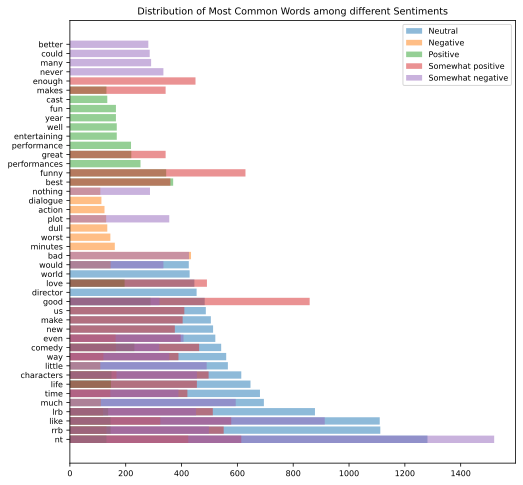

In [87]:
plt.figure(figsize=(8,8))
Plot_wordFrec(Neutral_Freq)
Plot_wordFrec(Negative_Freq)
Plot_wordFrec(Positive_Freq)
Plot_wordFrec(Somewhat_positive_Freq)
Plot_wordFrec(Somewhat_engative_Freq)
plt.legend(['Neutral','Negative','Positive','Somewhat positive','Somewhat negative'])
plt.title('Distribution of Most Common Words among different Sentiments')
plt.show()


随后我们利用`nltk`进行了一个初步的词频分析.选取了每组词频前20位的词语，并在常规禁用词外增加了我们前期看到的一些在本任务中比较常见但没有很大价值的词汇。可以看到特别高频出现的词汇依旧没有太大的感情色彩，在各组之间均有分布。但是次高频出现的词汇就能体现出比较明显的感情色彩。这提示这些次高频词汇可能是分析文本感情的关键。

## 文本向量化

我们采用了两种文本向量化的方法：

1. Bag-of-Words模型：将文本中的每个词语视为一个特征，每个词语出现的次数作为该特征的权重。	
2. TF-IDF模型：词频-逆文档频率模型，是一种统计方法，它是一种基于词袋模型改进的文本特征提取方法。词频（TF）表示词语在所有文本中出现的次数。逆文档频率（IDF）表示词语在文档（本例中为每个phrase）中出现的频率的负对数。IDF这个值越小，则该词语出现的次数越多，重要性越低。TF-IDF模型通过对每个词语的TF-IDF值进行加权，得到每个短句的权重。

这两种方法都不考虑文本的顺序，属于比较基础的NLP方法。

关于向量化后矩阵的具体意义，可以参考这篇文章：  
*[【Python数据分析】文本情感分析——电影评论分析（二）文本向量化建立模型总结与改进方向](https://www.cnblogs.com/gc2770/p/14929162.html)*
### 词袋模型

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# 将短语和标签提取出来
X = train_data['Phrase']  # 短语
y = train_data['Sentiment']  # 情感标签

# 将数据拆分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 文本向量化
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)


In [ ]:
print(X_train_vec)
print("词频矩阵：", X_train_vec.toarray())

  (0, 2244)	1
  (1, 14262)	1
  (1, 11383)	1
  (2, 14939)	1
  (2, 8967)	1
  (2, 506)	1
  (2, 13499)	1
  (2, 8052)	1
  (2, 13532)	1
  (2, 1962)	1
  (2, 8855)	1
  (2, 7419)	1
  (2, 5098)	1
  (2, 9377)	1
  (2, 14902)	2
  (2, 6784)	1
  (2, 13550)	1
  (2, 10261)	1
  (2, 8466)	1
  (3, 12431)	1
  (3, 1355)	1
  (3, 12256)	1
  (3, 1430)	1
  (3, 624)	1
  (3, 12484)	1
  :	:
  (124845, 9225)	1
  (124845, 8027)	1
  (124845, 13302)	1
  (124845, 14204)	1
  (124845, 8798)	1
  (124845, 3592)	1
  (124845, 9930)	1
  (124846, 506)	1
  (124846, 9377)	1
  (124846, 624)	1
  (124846, 15173)	1
  (124846, 9324)	1
  (124846, 7228)	1
  (124846, 1893)	1
  (124846, 8027)	1
  (124846, 6649)	1
  (124846, 13515)	1
  (124846, 10026)	1
  (124846, 10731)	1
  (124846, 8375)	1
  (124846, 2228)	1
  (124847, 624)	1
  (124847, 972)	1
  (124847, 4014)	1
  (124847, 4507)	1
词频矩阵： [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(X_val_vec)
print("词频矩阵:", X_val_vec.toarray())

  (0, 855)	1
  (0, 12464)	1
  (1, 137)	1
  (1, 624)	1
  (1, 1208)	1
  (1, 1246)	1
  (1, 1878)	1
  (1, 2585)	1
  (1, 2641)	1
  (1, 3448)	1
  (1, 3926)	1
  (1, 5117)	1
  (1, 6307)	1
  (1, 8339)	1
  (1, 9211)	1
  (1, 9377)	1
  (1, 11326)	1
  (1, 11747)	1
  (1, 13532)	1
  (1, 13675)	1
  (1, 13989)	1
  (2, 3310)	1
  (2, 9225)	1
  (2, 13528)	1
  (3, 5241)	1
  :	:
  (31202, 13675)	2
  (31203, 1799)	1
  (31204, 624)	1
  (31204, 4499)	1
  (31204, 6995)	1
  (31205, 4744)	1
  (31205, 13063)	1
  (31206, 6710)	1
  (31206, 10164)	1
  (31206, 13499)	1
  (31207, 4566)	1
  (31207, 5414)	1
  (31208, 6630)	1
  (31208, 15056)	1
  (31209, 465)	1
  (31209, 2732)	1
  (31209, 6784)	1
  (31209, 13499)	2
  (31209, 13500)	1
  (31210, 2435)	1
  (31210, 3203)	1
  (31210, 10054)	1
  (31211, 2386)	1
  (31211, 13499)	1
  (31211, 14719)	1
词频矩阵: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# 密集矩阵
X_train_vec.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
X_val_vec

<31212x15228 sparse matrix of type '<class 'numpy.int64'>'
	with 194056 stored elements in Compressed Sparse Row format>

`CountVectorizer`只会对字符长度不小于2的单词进行处理，如果单词只包含一个字符，这个单词就会被忽略。（修改`analyzer = char_wb`这个参数可以,如果需要进行更复杂的处理，可以修改`token_pattern`）注意 ，经过训练后，`CountVectorizer`就可以对测试集文件进行向量化了，但是向量化出来的特征只是训练集出现的单词特征，如果测试集出现了训练集中没有的单词，就无法在词袋模型中体现了。


In [ ]:
# 使用朴素贝叶斯分类器进行训练
model = MultinomialNB()
model.fit(X_train_vec, y_train)


MultinomialNB()

In [ ]:
# 在验证集上进行预测
y_val_pred = model.predict(X_val_vec)

# 输出分类报告
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.44      0.29      0.35      1416
           1       0.50      0.44      0.47      5527
           2       0.69      0.78      0.73     15639
           3       0.53      0.50      0.51      6707
           4       0.49      0.34      0.40      1923

    accuracy                           0.61     31212
   macro avg       0.53      0.47      0.49     31212
weighted avg       0.60      0.61      0.60     31212



In [ ]:
# 对于测试集进行预测

X_test = test_data['Phrase']

# 文本向量化测试集
X_test_vec = vectorizer.transform(X_test)

# 进行情感预测
y_test_pred = model.predict(X_test_vec)


In [ ]:
# 将预测结果保存到文件
submission = pd.DataFrame({'PhraseId': test_data['PhraseId'], 'Sentiment': y_test_pred})
print(submission)
# submission.to_csv(r'submission_bagging.csv', index=False)

# 疑似测试集有空数据导致无法转换为向量，因此需要做一下处理
# 参考：https://stackoverflow.com/questions/47064518/sklearn-text-vectorization-valueerror-input-contains-nan-infinity-or-a-value-too-larg


### TF-IDF转换
`scikit-learn`库中的tf-idf转换与标准公式稍微不同，会使用$L_1$或$L_2$范数进行归一化（默认为$L_2$范数）。

In [ ]:
# TF-IDF 文本向量化
# 可以采用nltk包的标准公式代替这个算法 --zyy
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer 结合了 CountVectorizer 和 TfidfTransformer 的功能
# 可以直接将文本数据转换为 TF-IDF 表示。

In [ ]:
vectorizer2 = TfidfVectorizer(stop_words='english')
X_train_vec2 = vectorizer2.fit_transform(X_train)
X_val_vec2 = vectorizer2.transform(X_val)

print(X_train_vec2.toarray())
print(X_val_vec2.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# 使用朴素贝叶斯分类器进行训练
model2 = MultinomialNB()
model2.fit(X_train_vec2, y_train)

y_val_pred2 = model2.predict(X_val_vec2)
print(classification_report(y_val, y_val_pred2))


              precision    recall  f1-score   support

           0       0.65      0.05      0.09      1416
           1       0.52      0.28      0.36      5527
           2       0.61      0.89      0.72     15639
           3       0.53      0.40      0.46      6707
           4       0.66      0.06      0.11      1923

    accuracy                           0.59     31212
   macro avg       0.59      0.33      0.35     31212
weighted avg       0.58      0.59      0.53     31212



In [ ]:
# 预测测试集
X_test_vec2 = vectorizer2.transform(X_test)
y_test_pred2 = model2.predict(X_test_vec2)

submission2 = pd.DataFrame({'PhraseId': test_data['PhraseId'], 'Sentiment': y_test_pred})
print(submission2)
# submission2.to_csv(r'submission_tfidf_MutiNB.csv', index=False)



## BERT

In [ ]:
# import transformers
from transformers import AutoModelForSequenceClassification,AutoTokenizer
import numpy as np # linear algebra
import torch

In [5]:
train = train_data.copy(deep = True)
test = test_data.copy(deep = True)

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
train['Phrase_Length'] = train['Phrase'].apply(len)

# 获取短语长度的统计信息
length_stats = train['Phrase_Length'].describe()
print(length_stats)

# 如果想查看短语长度的范围（最小值和最大值）
min_length = train['Phrase_Length'].min()
max_length = train['Phrase_Length'].max()

print(f"最小长度: {min_length}")
print(f"最大长度: {max_length}")


count    156060.000000
mean         40.217224
std          38.154130
min           1.000000
25%          14.000000
50%          26.000000
75%          53.000000
max         283.000000
Name: Phrase_Length, dtype: float64
最小长度: 1
最大长度: 283


In [9]:
# 加载 BERT 分词器
tokenizer = AutoTokenizer.from_pretrained("/lustre/user/liclab/lisky/buyf/Class/Introduce2Data/bert_base_uncased")

# 分词并编码
encoded_inputs = tokenizer(
    train["Phrase"].tolist(),  # 输入文本列表
    padding=True,            # 自动填充到相同长度
    truncation=True,         # 截断超长序列（BERT 最大长度 512）
    max_length=128,          # 最大序列长度（可以调整）
    return_tensors="pt"      # 返回 PyTorch 张量
)

print(encoded_inputs.keys())  # 包括 input_ids, attention_mask


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [10]:
# 打印 token_ids, token_type_ids, attention_mask
print("Input IDs:", encoded_inputs['input_ids'][1])
print("Token Type IDs:", encoded_inputs['token_type_ids'][1])
print("Attention Mask:", encoded_inputs['attention_mask'][1])

Input IDs: tensor([  101,  1037,  2186,  1997,  9686, 17695, 18673, 14313,  1996, 15262,
         3351,  2008,  2054,  2003,  2204,  2005,  1996, 13020,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Token Type IDs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:

# 指定本地模型路径
local_model_path = "/lustre/user/liclab/lisky/buyf/Class/Introduce2Data/bert_base_uncased"

# 加载模型
model = AutoModelForSequenceClassification.from_pretrained(
    local_model_path,  
    num_labels=5       
)

# 查看模型结构
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /lustre/user/liclab/lisky/buyf/Class/Introduce2Data/bert_base_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
from transformers import Trainer, TrainingArguments,EarlyStoppingCallback,EvalPrediction

In [13]:
# 训练参数
batch_size = 64  # 根据你的机器配置调整
metric_name = 'f1'  # 假设你选择F1分数作为最佳模型的评估指标

args = TrainingArguments(
    output_dir="./results",  # 模型保存路径
    eval_strategy="epoch",   # 每个 epoch 后评估
    save_strategy="epoch",   # 每个 epoch 后保存模型
    learning_rate=1e-5,      # 降低学习率
    per_device_train_batch_size=batch_size,  # 训练时的批大小
    per_device_eval_batch_size=batch_size,   # 评估时的批大小
    num_train_epochs= 50,     # 训练的总轮数
    weight_decay=0.1,       # 权重衰减（L2 正则化）
    load_best_model_at_end=True,  # 加载最优模型
    metric_for_best_model=metric_name,  # 选择最佳模型的指标
    logging_dir='./logs',   # 日志文件保存路径
    logging_steps=10,       # 每 10 步记录一次日志
    eval_steps=500,         # 每 500 步进行一次评估
    warmup_steps=500,       # 学习率热启动步数
    fp16=True,              # 启用混合精度训练
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,confusion_matrix

def multi_class_metrics(predictions, labels):
    softmax = torch.nn.Softmax(dim=-1) 
    probs = softmax(torch.Tensor(predictions))  # 获取每个类别的概率

    # 使用 argmax 将预测值转换为类别标签
    y_pred = np.argmax(probs, axis=1)

    # one-hot 编码
    y_true = labels

    # 计算 F1 score
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    
    # 计算 ROC AUC（需要每个类别的概率）
    roc_auc = roc_auc_score(y_true, probs, multi_class='ovr', average='macro')

    # 计算准确率
    accuracy = accuracy_score(y_true, y_pred)

    # 返回所有指标
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_class_metrics(predictions=preds, labels=p.label_ids)
    return result



In [15]:
labels = train['Sentiment'].tolist()  # 情感标签列表
# 将标签转换为张量
labels_tensor = torch.tensor(labels, dtype=torch.long)  # 确保类型为 torch.long

In [16]:
print(labels_tensor)

tensor([1, 2, 2,  ..., 3, 2, 2])


In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,Dataset,DataLoader

# 假设 encoded_inputs_dict 中包含 'input_ids', 'attention_mask', 'token_type_ids' 和 labels_tensor
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']
token_type_ids = encoded_inputs['token_type_ids']
labels = labels_tensor

# 使用 train_test_split 将数据集分割为训练集和验证集（80% 训练，20% 验证）
train_inputs, val_inputs, train_attention_mask, val_attention_mask, train_token_type_ids, val_token_type_ids, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, token_type_ids, labels, test_size=0.2, random_state=42
)

# 自定义 Dataset 类
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.labels = labels
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        # 返回一个字典
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'token_type_ids': self.token_type_ids[idx],
            'labels': self.labels[idx]
        }

# 创建训练集和验证集的 Dataset 实例
train_dataset = CustomDataset(train_inputs, train_attention_mask, train_token_type_ids, train_labels)
val_dataset = CustomDataset(val_inputs, val_attention_mask, val_token_type_ids, val_labels)

# 查看数据格式
print(train_dataset[0])  # 应该是字典形式的输出

# 输出数据集大小
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


{'input_ids': tensor([  101, 18178,  2229,  2100,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
# 配置早停回调
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)  # 在 2 次验证损失不下降时停止训练

# 设置 Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,  # 训练数据集
    eval_dataset=val_dataset,  # 验证数据集
    tokenizer=tokenizer,  # 使用的分词器
    compute_metrics=compute_metrics,  # 计算评估指标
    callbacks=[early_stopping]  # 添加早停回调
)


/tmp/ipykernel_3901173/1360408393.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [20]:
# 训练模型
trainer.train()

/lustre/user/liclab/lisky/buyf/ENTER/envs/d2l/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.947900,0.877695,0.639017,0.873499,0.639017
2,0.884500,0.830779,0.645969,0.892717,0.645969
3,0.804300,0.804763,0.659650,0.900052,0.659650
4,0.802800,0.825921,0.647571,0.900903,0.647571
5,0.747500,0.822857,0.650583,0.903984,0.650583


/lustre/user/liclab/lisky/buyf/ENTER/envs/d2l/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/lustre/user/liclab/lisky/buyf/ENTER/envs/d2l/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/lustre/user/liclab/lisky/buyf/ENTER/envs/d2l/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/lustre/user/liclab/lisky/buyf/ENTER/envs/d2l/lib/python3.9/site-packages/to

TrainOutput(global_step=2440, training_loss=0.9067691251879832, metrics={'train_runtime': 1502.8815, 'train_samples_per_second': 4153.621, 'train_steps_per_second': 16.235, 'total_flos': 2.56638858205824e+16, 'train_loss': 0.9067691251879832, 'epoch': 5.0})

In [24]:
# 训练结束后，最优模型已经被加载到 model 中
best_model = trainer.model  # 获取最优模型

model_save_path = "/lustre/user/liclab/lisky/buyf/Class/Introduce2Data/bast_model.pt"  # 设置保存路径
torch.save(best_model, model_save_path)

In [25]:
test["Phrase"] = test["Phrase"].fillna("")  # 用空字符串替代 NaN

# 对测试集的每一行进行分词和编码
encoded_inputs_test = tokenizer(
    test["Phrase"].tolist(),  # 测试集的文本列表
    padding=True,                  # 填充为相同长度
    truncation=True,               # 截断超长序列
    max_length=128,                # 最大序列长度
    return_tensors="pt"            # 返回 PyTorch 张量
)

# 输出看看处理结果
print(encoded_inputs_test.keys())  # 应该返回 input_ids 和 attention_mask


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [29]:
best_model_cpu = trainer.model.to('cpu')

# 
best_model_cpu.eval()
# 使用模型进行推理
with torch.no_grad():
    outputs = best_model_cpu(**encoded_inputs_test)

# 获取预测结果
predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

In [32]:
# 将预测结果与 PhraseId 合并
test_results = pd.DataFrame({
    "PhraseId": test["PhraseId"],  # 从测试集读取 PhraseId
    "Sentiment": predictions       # 模型预测的情感标签
})

# 保存为 CSV 文件
output_path = "/lustre/user/liclab/lisky/buyf/Class/Introduce2Data/test_results.csv"  # 指定保存路径
test_results.to_csv(output_path, index=False)

print(f"预测结果已保存至 {output_path}")

预测结果已保存至 /lustre/user/liclab/lisky/buyf/Class/Introduce2Data/test_results.csv


## Long Short-Term Memory Network(LSTM)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# 检查是否可以使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# 将TF-IDF数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train_vec2, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_val_vec2, dtype=torch.float32).to(device)


In [ ]:
# 创建自定义数据集类
class PhraseDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = features  # 特征数据
        self.labels = labels  # 标签数据
        
    def __len__(self):
        return len(self.features)  # 返回数据集的长度
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]  # 返回特征和标签
        else:
            return self.features[idx]  # 只返回特征

# 准备数据集
train_labels = train['Sentiment'].values  # 获取训练集标签
train_dataset = PhraseDataset(X_train_tensor, train_labels)  # 创建训练数据集

In [ ]:
from torch.utils.data import random_split

# 将数据集拆分为训练集和验证集
train_size = int(0.8 * len(train_dataset))  # 计算训练集大小
val_size = len(train_dataset) - train_size  # 计算验证集大小
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])  # 拆分数据集
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)  # 创建训练数据加载器
val_loader = DataLoader(val_subset, batch_size=32)  # 创建验证数据加载器


In [ ]:
# 定义情感分类模型
class SentimentNN(nn.Module):
    def __init__(self, input_dim, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # 第一个全连接层
        self.fc2 = nn.Linear(64, 32)  # 第二个全连接层
        self.fc3 = nn.Linear(32, output_size)  # 输出层
        self.dropout = nn.Dropout(0.5)  # Dropout层，防止过拟合

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 应用ReLU激活函数
        x = self.dropout(x)  # 应用Dropout
        x = F.relu(self.fc2(x))  # 应用ReLU激活函数
        x = self.dropout(x)  # 应用Dropout
        x = self.fc3(x)  # 输出层
        return x

# 设置训练参数
input_dim = X_train.shape[1]  # 输入维度
output_size = 5  # 输出类别数
net = SentimentNN(input_dim, output_size).to(device)  # 创建模型并移动到指定设备
net.train()  # 设置模型为训练模式

In [ ]:
# 设置超参数
epochs = 100  # 训练轮数
lr = 0.001  # 学习率

optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # 优化器
criterion = nn.CrossEntropyLoss()  # 损失函数

# 早停设置
best_val_acc = 0  # 最佳验证准确率
patience = 10  # 早停耐心值
counter = 0  # 早停计数器

# 训练循环
for e in range(epochs):
    net.train()  # 设置模型为训练模式
    running_loss = 0.0  # 记录训练损失
    running_acc = 0.0  # 记录训练准确率

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移动到指定设备

        optimizer.zero_grad()  # 清零梯度
        
        output = net(inputs)  # 前向传播

        loss = criterion(output, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

        running_loss += loss.item()  # 累加损失
        running_acc += (output.argmax(dim=1) == labels).float().mean()  # 累加准确率

    print(f"Epoch {e + 1}/{epochs}, Loss: {running_loss / len(train_loader):.6f}, Acc: {running_acc / len(train_loader):.6f}")


In [ ]:
    # 验证阶段
    net.eval()  # 设置模型为评估模式
    val_loss = 0.0  # 记录验证损失
    val_acc = 0.0  # 记录验证准确率
    with torch.no_grad():  # 关闭梯度计算
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)  # 将数据移动到指定设备
            val_output = net(val_inputs)  # 前向传播
            val_loss += criterion(val_output, val_labels).item()  # 累加损失
            val_acc += (val_output.argmax(dim=1) == val_labels).float().mean().item()  # 累加准确率

    val_acc /= len(val_loader)  # 计算平均验证准确率
    print(f"Validation Loss: {val_loss / len(val_loader):.6f}, Validation Accuracy: {val_acc:.6f}")

    # 早停检查
    if val_acc > best_val_acc:
        best_val_acc = val_acc  # 更新最佳验证准确率
        counter = 0  # 重置早停计数器
    else:
        counter += 1  # 增加早停计数器
        if counter >= patience:
            print("Early stopping triggered.")  # 触发早停
            break

# 测试集预测
net.eval()  # 设置模型为评估模式
test_predictions = []  # 存储测试集预测结果
with torch.no_grad():  # 关闭梯度计算
    test_loader = DataLoader(PhraseDataset(X_test_tensor), batch_size=32)  # 创建测试数据加载器
    for test_inputs in test_loader:
        test_inputs = test_inputs.to(device)  # 将数据移动到指定设备
        test_output = net(test_inputs)  # 前向传播
        test_predictions.extend(test_output.argmax(dim=1).cpu().numpy())  # 存储预测结果

# 创建输出DataFrame，包含PhraseId和Sentiment
output_df = pd.DataFrame({
    'PhraseId': test['PhraseId'],  # 确保'PhraseId'对应于测试集中的正确列
    'Sentiment': test_predictions
})

# 保存预测结果到CSV文件
output_path = 'E:/shuju/answer/predictions.csv'

# 如果输出目录不存在，则创建
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# 保存预测结果
output_df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

## XGBoost

In [2]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier

In [9]:
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

In [10]:
X = X_train_vec
y = y_train

使用`XGBoost`训练模型，并用`optuna`调参

In [32]:
import optuna

In [ ]:
# 定义目标函数，用于Optuna调参
def objective(trial):
    # 为XGBClassifier的参数进行采样
    params = {
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.4, 0.8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 0.9),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 6000),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'gamma': trial.suggest_float('gamma', 0.1, 5),
        'random_state': 42
    }
    
    # 创建XGBClassifier
    xgb = XGBClassifier(
        silent=False,
        **params
    )
    
    # 训练模型
    xgb.fit(X_train_vec, y_train)
    
    # 预测测试集
    predictions = xgb.predict(X_val_vec)
    
    # 计算准确率
    accuracy = accuracy_score(y_val, predictions)
    
    # 返回准确率，Optuna将根据此值进行优化
    return accuracy

In [41]:
%%time
#使用optuna调参
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# 输出最佳参数和结果
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print(" Value: {}".format(trial.value))
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

[I 2024-11-24 11:03:50,065] A new study created in memory with name: no-name-82f524c1-b4f3-437c-8131-82f7487ade5f
[I 2024-11-24 11:09:27,259] Trial 0 finished with value: 0.6109509163142381 and parameters: {'scale_pos_weight': 0.6006473355583786, 'learning_rate': 0.09891118807099304, 'colsample_bytree': 0.38534312204559895, 'subsample': 0.7121797863893894, 'n_estimators': 4946, 'reg_alpha': 0.6685787317889744, 'max_depth': 5, 'gamma': 3.9467694643850826}. Best is trial 0 with value: 0.6109509163142381.
[I 2024-11-24 11:13:04,158] Trial 1 finished with value: 0.6326733307702166 and parameters: {'scale_pos_weight': 0.5839445514564013, 'learning_rate': 0.0738037473081925, 'colsample_bytree': 0.1937217887219025, 'subsample': 0.7421060946302614, 'n_estimators': 2043, 'reg_alpha': 0.4203840193310351, 'max_depth': 10, 'gamma': 1.3083655039168633}. Best is trial 1 with value: 0.6326733307702166.
[I 2024-11-24 11:25:43,764] Trial 2 finished with value: 0.6025246699987185 and parameters: {'scale

Number of finished trials:  20
Best trial:
 Value: 0.6495899013200052
 Params: 
 scale_pos_weight: 0.49532624101490497
 learning_rate: 0.07893912053609671
 colsample_bytree: 0.7032087285255331
 subsample: 0.781689529704698
 n_estimators: 3355
 reg_alpha: 0.5267978486476341
 max_depth: 7
 gamma: 0.5521902572655487
CPU times: total: 13h 3min 1s
Wall time: 2h 32min 49s


使用optuna设置20个trial根据准确率调整模型的参数，最终trial 7为最优，准确率为0.6495899对应参数为
Params: 
 scale_pos_weight: 0.49532624101490497
 learning_rate: 0.07893912053609671
 colsample_bytree: 0.7032087285255331
 subsample: 0.781689529704698
 n_estimators: 3355
 reg_alpha: 0.5267978486476341
 max_depth: 7
 gamma: 0.5521902572655487

In [42]:
trial

FrozenTrial(number=7, state=1, values=[0.6495899013200052], datetime_start=datetime.datetime(2024, 11, 24, 11, 56, 37, 533375), datetime_complete=datetime.datetime(2024, 11, 24, 12, 5, 10, 410825), params={'scale_pos_weight': 0.49532624101490497, 'learning_rate': 0.07893912053609671, 'colsample_bytree': 0.7032087285255331, 'subsample': 0.781689529704698, 'n_estimators': 3355, 'reg_alpha': 0.5267978486476341, 'max_depth': 7, 'gamma': 0.5521902572655487}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'scale_pos_weight': FloatDistribution(high=0.8, log=False, low=0.4, step=None), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'subsample': FloatDistribution(high=0.9, log=False, low=0.3, step=None), 'n_estimators': IntDistribution(high=6000, log=False, low=2000, step=1), 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'max_depth': In

使用调参得到的最佳参数训练模型

In [43]:
parameters={'scale_pos_weight': 0.49532624101490497, 'learning_rate': 0.07893912053609671, 'colsample_bytree': 0.7032087285255331, 'subsample': 0.781689529704698, 'n_estimators': 3355, 'reg_alpha': 0.5267978486476341, 'max_depth': 7, 'gamma': 0.5521902572655487}
xgb = XGBClassifier(silent=False, 
                      **parameters)

In [44]:
%%time
xgb.fit(X_train_vec,y_train)

CPU times: total: 43min 57s
Wall time: 8min 59s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7032087285255331, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5521902572655487,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07893912053609671,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3355, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

对验证集进行预测，评估模型指标

In [45]:
%%time
# Prediction on validation set
y_pred = xgb.predict(X_val_vec)

# Evaluating accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

#classification report
report = classification_report(y_val, y_pred)
print(report)

Validation Accuracy: 0.6493976675637575
              precision    recall  f1-score   support

           0       0.56      0.33      0.41      1416
           1       0.59      0.37      0.45      5527
           2       0.67      0.90      0.77     15639
           3       0.62      0.45      0.52      6707
           4       0.60      0.38      0.47      1923

    accuracy                           0.65     31212
   macro avg       0.61      0.48      0.52     31212
weighted avg       0.64      0.65      0.62     31212

CPU times: total: 2min 11s
Wall time: 21.7 s


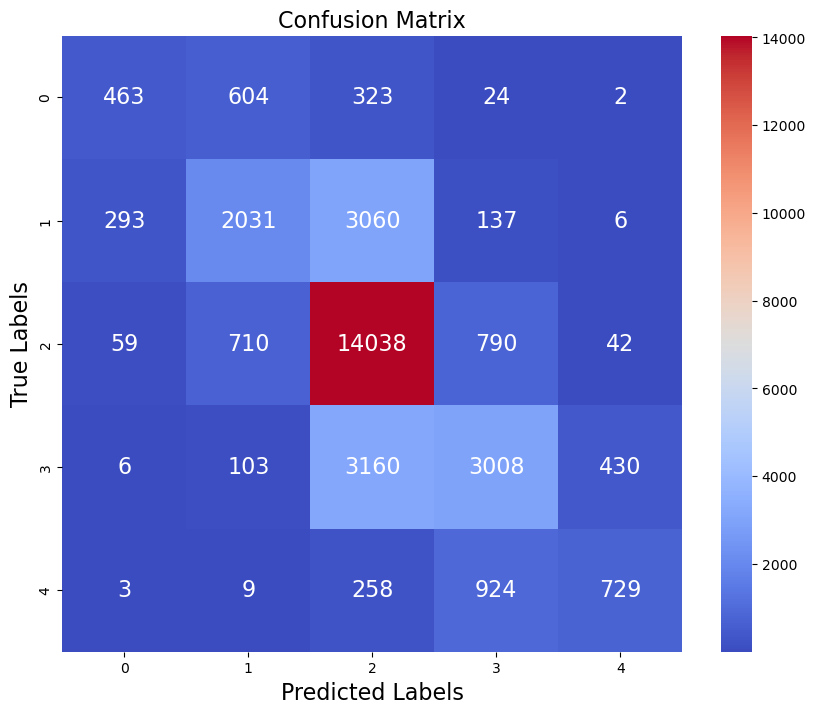

In [46]:
# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels',fontsize=16)
plt.ylabel('True Labels',fontsize=16)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

检查测试集中是否存在NaN

使用\<UNK>填补缺失值

In [48]:
X_test=test['Phrase']
#填补缺失值
X_test.fillna('<UNK>', inplace=True)

In [49]:
nan_mask = pd.isnull(X_test)  # 或者使用 pd.isna(X_test)
if nan_mask.any().any():  # 检查是否有任何NaN值
    print("存在NaN值")
else:
    print("不存在NaN值")

不存在NaN值


In [50]:
X_test_vec =vectorizer.transform(X_test)

In [51]:
%%time
# Prediction on test set
xgb_predict=xgb.predict(X_test_vec)

CPU times: total: 4min 49s
Wall time: 52 s


In [52]:
xgb_predict

array([3, 3, 2, ..., 2, 2, 2], dtype=int64)

生成测试结果提交文件

In [53]:
submission_file =pd.read_csv("E:\course\大三秋\数据科学导引\input\sampleSubmission.csv",sep=',')
submission_file['Sentiment']=xgb_predict
submission_file

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
...,...,...
66287,222348,1
66288,222349,1
66289,222350,2
66290,222351,2


In [54]:
submission_file.to_csv('Submission_XGB.csv',index=False)

在kaggle上提交Submission_XGB.csv，XGBoost模型的预测准确率为0.61932